# End to End 2D-Texture CNN for GTzan music classification EnvCNN


#### WINDOWED Version

### Adapted by AL Koerich

#### To GTzan 3-fold

##### 26 February 2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os, sys
import soundfile as sf

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from keras import regularizers

import os, sys
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Conv1D, Dense, MaxPool1D, Flatten
from keras.callbacks import TensorBoard
from keras.utils import np_utils, to_categorical
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
import keras.initializers as init

os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
config = tf.ConfigProto( )
config.gpu_options.allow_growth = True
sess   = tf.Session(config=config)
import keras.backend.tensorflow_backend as tf_bkend
tf_bkend.set_session(sess)

Using TensorFlow backend.


In [2]:
#controling_Hyper parameters
batch_size = 100
nb_classes = 10
nb_epoch   = 300
frame_size = 110250

In [3]:
X_train = np.load( "/home-2/akoerich/GTzan_Xs_fold1-2_110250_75.npy" )
Y_train = np.load( "/home-2/akoerich/GTzan_Ys_fold1-2_110250_75.npy" )
# t_train = np.load( "t_train_13_220500_50_256_box_id.npy" )
# s_train = np.load( "s_train_13_220500_50_256_box_id.npy" )


X_valid = np.load( "/home-2/akoerich/GTzan_Xs_fold3_110250_75.npy" )
Y_valid = np.load( "/home-2/akoerich/GTzan_Ys_fold3_110250_75.npy" )
# t_valid = np.load( "t_valid_2_220500_50_256_box_id.npy" )
# s_valid = np.load( "s_valid_2_220500_50_256_box_id.npy" )

In [4]:
X_train.min(), X_train.max()

(-1.0, 1.0000000000000004)

In [5]:
X_valid.min(), X_valid.max()

(-1.0, 1.0000000000000004)

In [6]:
# Adapt 1D data to 2D CNN
X_train = np.squeeze( X_train)
X_train = np.expand_dims( X_train, axis = 1 )

X_valid = np.squeeze( X_valid )
X_valid = np.expand_dims( X_valid, axis = 1 )

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

((16741, 1, 110250), (16741, 10), (8249, 1, 110250), (8249, 10))

In [7]:
import gc
gc.collect()

7

In [8]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

((16741, 1, 110250), (16741, 10), (8249, 1, 110250), (8249, 10))

In [24]:
def model_generator_GTzannet2D_1a():
    
    from keras.layers      import Input, Dense, Conv2D, AveragePooling1D, LeakyReLU, MaxPool2D, Flatten
    from keras.layers.core import Dropout
    from keras.models      import Model
    from keras             import initializers, optimizers, regularizers
    from keras.callbacks   import ModelCheckpoint
    from keras.utils       import multi_gpu_model
    
    from keras.layers.normalization import BatchNormalization
        
    import keras.initializers as init
    
    from kapre.time_frequency import Melspectrogram
    from kapre.utils          import Normalization2D
    from kapre.augmentation   import AdditiveNoise    
    
    sr = 22050
    
    inp   = Input(shape = (1, frame_size) )
    #----------------------
    spec  = Melspectrogram(n_dft = 512, n_hop = 256, padding = 'same', sr = sr, n_mels = 64,
                           fmin = 0.0, fmax = sr/2, power_melgram = 1.0,
                           return_decibel_melgram = False, trainable_fb = False,
                           trainable_kernel = False,
                           name = 'static_stft')(inp)    
    #----------------------
    conv1  = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu')(spec)
    norm1  = BatchNormalization()(conv1)
    #----------------------
    conv2  = Conv2D(filters = 32, kernel_size = (3, 3) )(norm1)
    act2   = LeakyReLU(alpha = 0.2)(conv2)
    pool2  = MaxPool2D(pool_size = 2, strides = 2)(act2)
    drop2  = Dropout(0.05)(pool2)
    #----------------------
    conv3  = Conv2D(filters = 64, kernel_size = (3, 3) )(drop2)
    act3   = LeakyReLU(alpha = 0.2)(conv3)
    #----------------------
    conv4  = Conv2D(filters = 64, kernel_size = (3, 3) )(act3)
    act4   = LeakyReLU(alpha = 0.2)(conv4)
    pool4  = MaxPool2D(pool_size = 4, strides = 2)(act4)
    #----------------------
    flat   = Flatten()(pool4)
    #----------------------    
    #dense1 = Dense(1024, activation='relu', kernel_initializer = initializers.glorot_uniform( seed = 0) )(flat)
    #drop1  = Dropout(0.80)(dense1)    
    #----------------------    
    #dense2 = Dense(128, activation='relu', kernel_initializer = initializers.glorot_uniform( seed = 0) )(flat)
    #drop2  = Dropout(0.80)(dense2)    
     #----------------------    
    dense3 = Dense(1024, activation='relu', kernel_initializer = initializers.glorot_uniform( seed = 0) )(flat)
    drop3  = Dropout(0.80)(dense3)    
    #----------------------
    dense4 = Dense(nb_classes, activation='softmax')(drop3)
    #----------------------

    model  = Model(inp, dense4)

    model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizers.Adadelta( lr = 1.0, rho = 0.95, epsilon = 1e-08, decay = 0.0),
                  metrics = ['accuracy'] )
    
    model.summary()
    
    return model

In [27]:
def model_generator_GTzannet2DTexture_1a():
    
    from keras.layers      import Input, Dense, Conv2D, AveragePooling1D, LeakyReLU, MaxPool2D, Flatten, AveragePooling2D
    from keras.layers.core import Dropout
    from keras.models      import Model
    from keras             import initializers, optimizers, regularizers
    from keras.callbacks   import ModelCheckpoint
    from keras.utils       import multi_gpu_model
    
    from keras.layers.normalization import BatchNormalization
        
    import keras.initializers as init
    
    from kapre.time_frequency import Melspectrogram
    from kapre.utils          import Normalization2D
    from kapre.augmentation   import AdditiveNoise    
    
    sr = 22050
    
    inp   = Input(shape = (1, frame_size) )
    #----------------------
    #spec  = Melspectrogram(n_dft = 512, n_hop = 256, padding = 'same', sr = sr, n_mels = 32,
    #                       fmin = 0.0, fmax = sr, power_melgram = 1.0,
    #                       return_decibel_melgram = False, trainable_fb = False,
    #                       trainable_kernel = False,
    #                       name = 'static_stft')(inp)    
    
    spec = Spectrogram(n_dft=512, n_hop=256,
                       return_decibel_spectrogram=False, power_spectrogram=2.0,
                       trainable_kernel=False, name='melgram')(inp)

    
    #----------------------
    conv1  = Conv2D(filters = 32, kernel_size = (3, 3), strides=(1, 1), name="conv1", padding="same", activation = 'relu')(spec)
    norm1  = BatchNormalization()(conv1)
    #----------------------
    conv2  = Conv2D(filters = 32, kernel_size = (3, 3), strides=(1, 1), name="conv2", padding="same", activation = 'relu')(norm1)
    act2   = LeakyReLU(alpha = 0.2)(conv2)
    
    pool2  = AveragePooling2D(pool_size = (257, 431), strides = 1)(act2)
    #drop2  = Dropout(0.90)(pool2)
    #----------------------
    flat   = Flatten()(pool2)
    #----------------------    
    #dense1 = Dense(1024, activation='relu', kernel_initializer = initializers.glorot_uniform( seed = 0) )(flat)
    #drop1  = Dropout(0.80)(dense1)    
    #----------------------    
    #dense2 = Dense(128, activation='relu', kernel_initializer = initializers.glorot_uniform( seed = 0) )(flat)
    #drop2  = Dropout(0.80)(dense2)    
     #----------------------    
    dense3 = Dense(21, activation='relu', kernel_initializer = initializers.glorot_uniform( seed = 0) )(flat)
    drop3  = Dropout(0.10)(dense3)    
    #----------------------
    dense4 = Dense(nb_classes, activation='softmax')(drop3)
    #----------------------

    model  = Model(inp, dense4)

    model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizers.Adadelta( lr = 1.0, rho = 0.95, epsilon = 1e-08, decay = 0.0),
                  metrics = ['accuracy'] )
    
    model.summary()
    
    return model



In [28]:
fold = '3'
import time
from keras.callbacks import ModelCheckpoint
from livelossplot    import PlotLossesKeras
from keras           import optimizers
hist = []

model = model_generator_GTzannet2DTexture_1a()

#checkpoints
str0 = "weights/"
str1 = "weights_GTzan_3f_Train1-2_110250_75_2DTexture_dense21" 
str2 = ".best.hdf5" 
filepath = str0+str1+str2 
print(filepath)

checkpoint = ModelCheckpoint( filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max' ) 

callbacks_list = [ checkpoint, PlotLossesKeras() ]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1, 110250)         0         
_________________________________________________________________
static_stft (Spectrogram)    (None, 257, 431, 1)       263168    
_________________________________________________________________
conv1 (Conv2D)               (None, 257, 431, 32)      320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 257, 431, 32)      128       
_________________________________________________________________
conv2 (Conv2D)               (None, 257, 431, 32)      9248      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 257, 431, 32)      0         
_________________________________________________________________
average_pooling2d_5 (Average (None, 1, 1, 32)          0         
__________

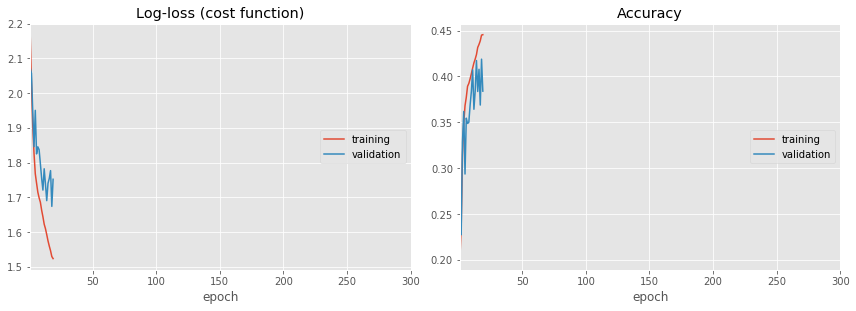

Log-loss (cost function):
training   (min:    1.523, max:    2.168, cur:    1.523)
validation (min:    1.674, max:    2.073, cur:    1.752)

Accuracy:
training   (min:    0.201, max:    0.446, cur:    0.446)
validation (min:    0.227, max:    0.419, cur:    0.384)
Epoch 20/300
 4140/16741 [======>.......................] - ETA: 7:30 - loss: 1.5036 - acc: 0.4609

In [ ]:
#fitting the model 
batch_size = 60
hist.append(model.fit(X_train, Y_train,
                      batch_size = batch_size, 
                      epochs     = nb_epoch,
                      verbose    = 1,
                      shuffle    = True,
                      callbacks  = callbacks_list,
                      validation_data = (X_valid, Y_valid)
                     ))

https://www.music-ir.org/nema_out/mirex2017/results/act/latin_report/accperfold.html

MIREX 2017:



Summary Results    [top]
Algorithm
Classification Accuracy
Normalised Classification Accuracy
LPNKK1
0.7586
0.7571
PLNPH1
0.6619
0.6573
XLJ1
0.6148
0.6079
LPNKK3
0.7347
0.7324
LPNKK2
0.6511
0.6458





Fold
LPNKK1
LPNKK2
LPNKK3
PLNPH1
XLJ1
1
0.7186
0.6041
0.6860
0.5795
0.5453
0
0.7627
0.6426
0.7444
0.6772
0.5998
2
0.8055
0.7194
0.7872
0.7518
0.7183


/Users/akoerich/Dropbox/Mendeley/pdf/Aytar, Vondrick, Torralba - 2016.pdf

/Users/akoerich/HOME/ETS/Etudiants/Sajjad Abdoli/DGA1032/DGA1032-Dissertation_abdoli.pdf

* Texture 64 - 256
Accuracy:
training   (min:    0.176, max:    0.741, cur:    0.737)
validation (min:    0.303, max:    0.640, cur:    0.454)
In [14]:
